# ZFX
[X-linked syndromic intellectual developmental disorder-37 (MRXS37)](https://omim.org/entry/301118) is caused by hemizygous or heterozygous mutation in the ZFX gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.2


### ZFX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZFX.

In [2]:
gene_symbol = 'ZFX'
mane_tx_id = 'NM_003410.4'
mane_protein_id = 'NP_003401.2' # zinc finger X-chromosomal protein isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 19/19 [00:39<00:00,  2.08s/ individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
16,Delayed fine motor development
16,Delayed speech and language development
15,Delayed ability to walk
13,Hypotonia
13,Inguinal hernia
12,Thin upper lip vermilion
9,Caesarian section
9,Umbilical hernia
9,Macroglossia
9,Autism


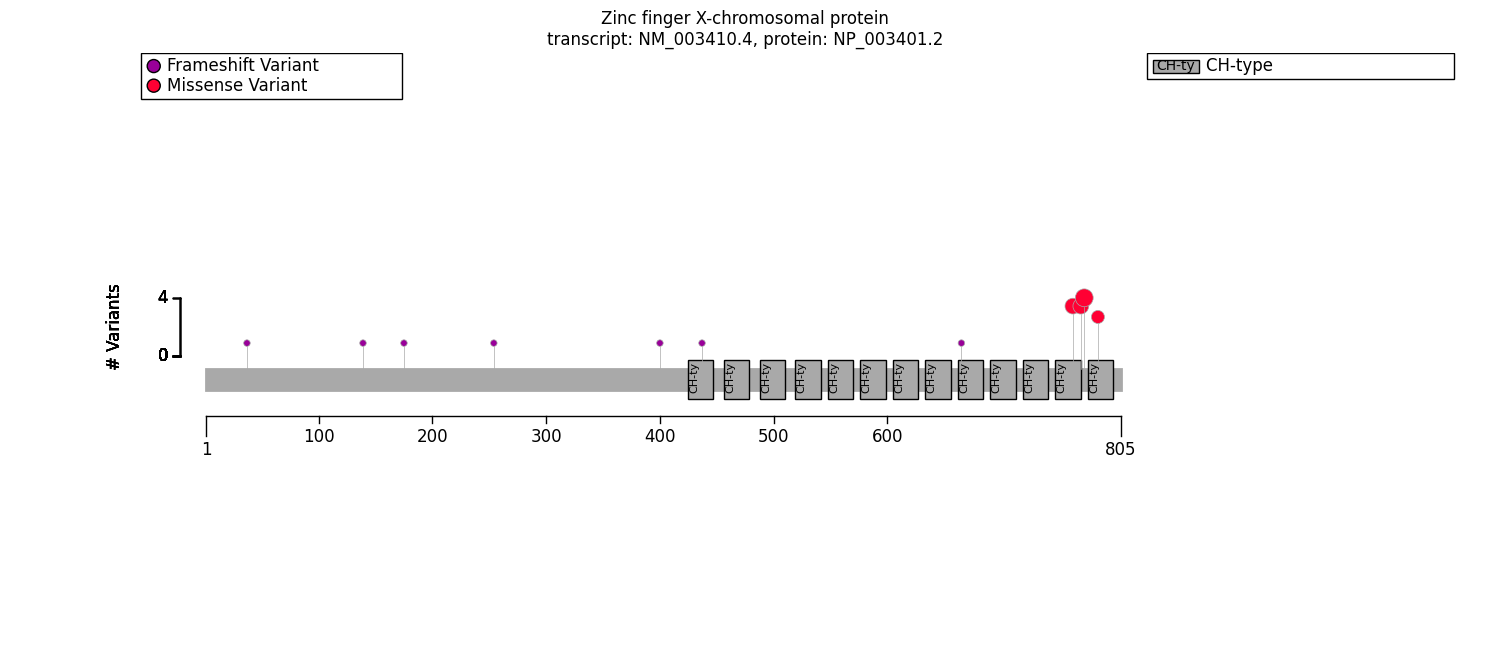

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

zfx_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
zfx_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

[Shepherdson JL, et al. (2024) Variants in ZFX are associated with an X-linked neurodevelopmental disorder with recurrent facial gestalt. Am J Hum Genet](https://pubmed.ncbi.nlm.nih.gov/38325380/)
noted that

> the ZFX variant (c.2357G>A [p.Arg786Gln]) found in [a family with MRXS37] has been previously reported as a somatic variant in sporadic parathyroid adenoma.

[Guan B, et al. (2024). A Germline ZFX Missense Variant in a Patient With Primary Hyperparathyroidism. JCEM Case Rep](https://pubmed.ncbi.nlm.nih.gov/39056049/) reported an additional individual with primary hyperparathyroidism (PHPT)  and state

> The subset of [MRXS37] patients with PHPT all had missense variants located within or between zinc-finger domains 12 or 13.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer


missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,159
HMF03,Skipping term because of a child term with the same individual counts,16
HMF08,Skipping general term,103
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,254


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                               missense         other          \
                                              Count Percent Count Percent   
Melanocytic nevus [HP:0000995]                 7/12     58%   0/7      0%   
Hyperparathyroidism [HP:0000843]                7/9     78%   0/5      0%   
Umbilical hernia [HP:0001537]                  8/11     73%   1/7     14%   
Intellectual disability, mild [HP:0001256]     6/11     55%   0/4      0%   
Thick eyebrow [HP:0000574]                     5/12     42%   0/7      0%   
...                                             ...     ...   ...     ...   
Abnormal tongue morphology [HP:0030809]         7/7    100%   2/2    100%   
Skeletal muscle hypertrophy [HP:0003712]        7/7    100%   2/2    100%   
Abnormality of the forehead [HP:0000290]        4/4    100%   5/5    100%   
Autism [HP:0000717]                            6/11     55%   3/7     43%   
Autistic behavior [HP:0000729]                  6/6    100%   3/3    100%   

Allele group                                                             
                                           Corrected p values  p values  
Melanocytic nevus [HP:0000995]                       0.692308  0.017405  
Hyperparathyroidism [HP:0000843]                     0.692308  0.020979  
Umbilical hernia [HP:0001537]                        1.000000  0.049774  
Intellectual disability, mild [HP:0001256]           1.000000  0.103297  
Thick eyebrow [HP:0000574]                           1.000000  0.106037  
...                                                       ...       ...  
Abnormal tongue morphology [HP:0030809]              1.000000  1.000000  
Skeletal muscle hypertrophy [HP:0003712]             1.000000  1.000000  
Abnormality of the forehead [HP:0000290]             1.000000  1.000000  
Autism [HP:0000717]                                  1.000000  1.000000  
Autistic behavior [HP:0000729]                       1.000000  1.000000  

[66 rows x 6 columns]

In [10]:
# On the basis of the literature, one can test the hypothesis of a differential frequency of Hyperparathyroidism

from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.pcats import HpoTermAnalysis


specified_terms = SpecifiedTermsMtcFilter(
    terms_to_test=(
        "HP:0000843",  # Hyperparathyroidism
    )
)

count_statistic = FisherExactTest()

mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
hyperparathyroid_analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

hyperparathyroid_missense_result = hyperparathyroid_analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=hyperparathyroid_missense_result)

Allele group                     missense         other          \
                                    Count Percent Count Percent   
Hyperparathyroidism [HP:0000843]      7/9     78%   0/5      0%   

Allele group                                                   
                                 Corrected p values  p values  
Hyperparathyroidism [HP:0000843]           0.020979  0.020979

# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

ft_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=hyperparathyroid_missense_result
    ),
)

caption = """The small cohort size and the fact that the majority of the ZFX variants were private to each proband or 
family made the assessment of genotype-phenotype correlation difficult. A recent report of a
germline ZFX missense variant in a patient With primary hyperparathyroidism suggested the hypothesis of
testing for correlation between missense variants and hyperparathyroidism \\cite{PMID_38325380,PMID_39056049}."""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=ft_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [14]:
summarizer.process_latex(report=report, protein_fig=zfx_fig)

Figure saved to ../../supplement/img/ZFX_protein_diagram-draft.pdf
Output to ../../supplement/tex/ZFX_summary_draft.tex
